# HDSC: knowledge base embedding

Let's import all the libraries needed for our knowledge base embedding.

In [2]:
import os
import numpy as np
import xarray as xr
import warnings
import torchhd
import torch
from tqdm import tqdm
from urllib3.exceptions import NotOpenSSLWarning
import matplotlib.pyplot as plt


Now, let's configure the runtime environment settings.

In [3]:
# I/O configuration
input_folder = '../data/ncdf'
output_folder = '../data/ncdf'

# Runtime configuration
os.makedirs(output_folder, exist_ok=True)

# Ignore annoying urllib3 warnings
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

# Load dataset
dataset = xr.load_dataarray(os.path.join(input_folder, "nrm.orx.dataset.nc"))

Our refined dataset can be used in two ways:
- "as-is" version: no modifications to original data is applied. This means that we should then use an HDC/VSA encoding compatible with the data format (i.e. real numbers). The dimensionality of the signals of the original dataset can be augmented by interpolation, as shown in the etl.ipynb notebook.
- "hyperdimensional embedded" version. We apply a linear/non-linear projection to our signals, in order to gain the possibility to automatically embed in lower/higher dimensional space (no interpolations needed), as well as choosing the data format (boolean, real, or complex numbers). A desired property for our embeddings is, of course, similarity-preservation.

HRRTensor([[ 3.1013, -0.7768, -1.4692,  ...,  1.7206, -1.3330,  1.0902]])


<StemContainer object of 3 artists>

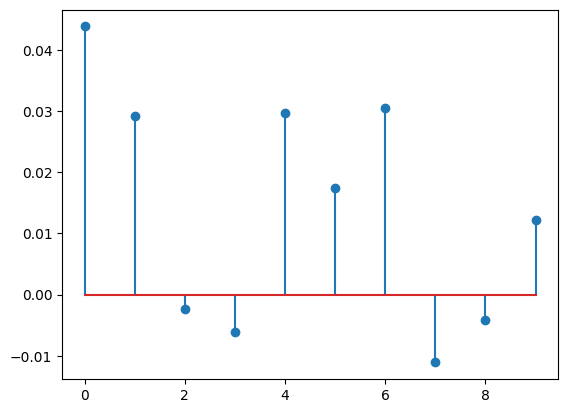

In [4]:
unembedded_signals = torchhd.HRRTensor(dataset.sel(radius=10).values)
frequency_labels = torchhd.HRRTensor(torch.randn(10, dataset.time.size))

kbe = torchhd.hash_table(unembedded_signals, frequency_labels)
query = torchhd.inverse(unembedded_signals[0])
result = torchhd.bind(kbe, query)

# Now let's perform a memory cleanup: the result vector should be the closest to our simulated signal at frequency=1MHz
print(torchhd.cleanup(result, frequency_labels))

torchhd.utils.plot_similarity(result, frequency_labels)

In [5]:
HRRDataset = torchhd.HRRTensor(dataset.values).flatten(0,1)

In [6]:
HRRDataset = torchhd.HRRTensor(dataset.values).flatten(0,1)
HRRDataset = torchhd.HRRTensor(dataset.sel(radius=slice(100, 300)).values).flatten(0,1)

# Normalize each row (vector) to unit norm
normed = torch.nn.functional.normalize(HRRDataset, p=2, dim=1)

# Compute pairwise cosine similarity: [450, 450]
similarity_matrix = normed @ normed.T

# Convert to numpy for plotting
sim_np = similarity_matrix.cpu().numpy()

# Plot
#
# plt.figure(figsize=(14, 12))
# plt.rcParams['figure.dpi'] = 300
# plt.imshow(sim_np, cmap="viridis", aspect="auto")
# plt.colorbar(label="Cosine similarity")
# plt.title("Pairwise Cosine Similarity (HRRDataset)")
# plt.xlabel("Vector index")
# plt.ylabel("Vector index")
# plt.tight_layout()
# plt.show()

Just running a few simulation of the previous cell, we can see through the plot that the element in position 0 (i.e. radius = 10) has stronger similarity to our dictionary classification around 1 out of 10 trials. Naturally, this is not acceptable; we then have to encode our signals in a way that allows to 1. preserve the signal information geometry and 2. provide accurate classifications. 

The torchhd framework provides several encoding methods; we will test their level of similarity-preservation with the following experiment. The cell below executes a simulation averaging the cosine similarity between pairs $(x, y)$ and $(\Gamma(x), \Gamma(y))$, where x and y are really similar, and $\Gamma(x)$ and $\Gamma(y)$ should be similar if the embedding $\Gamma$ is similarity-preserving.

In [13]:
n = 10000
no_simulations = 100

# Circular, thermometer embeddings are computationally very expensive and prone to memory overflow and crashes.

fractional = torchhd.embeddings.FractionalPower(n, n, vsa="HRR")
projection = torchhd.embeddings.Projection(n, n, vsa="HRR")
sinusoid = torchhd.embeddings.Sinusoid(n, n, vsa="HRR")
density = torchhd.embeddings.Density(n, n, vsa="FHRR")

hdembed = {
    "fractional": fractional,
    "projection": projection,
    "sinusoid": sinusoid,
    "density": density
}

avg_cos_sim = {name: 0.0 for name in hdembed.keys()}
avg_cos_sim["baseline"] = 0.0

for _ in tqdm(range(no_simulations), desc="HDC embedding"):
    x = torch.randn(1, 10000)
    epsilon = 0.01
    noise = (torch.rand_like(x) - 0.5) * 2 * epsilon  # uniform in [-epsilon, +epsilon]
    y = x + noise
    cos_sim_orig = torchhd.cosine_similarity(x, y).item()
    avg_cos_sim["baseline"] += cos_sim_orig
    for name, emb in hdembed.items():
        x_hd, y_hd = hdembed[name](x), hdembed[name](y)
        cos_sim = torchhd.cosine_similarity(x_hd, y_hd).item()
        avg_cos_sim[name] += cos_sim

for name in avg_cos_sim:
    avg_cos_sim[name] /= no_simulations

print("Cosine similarity levels for encoding method:")
for name, sim in avg_cos_sim.items():
    print(f"{name:<10} :: {sim:.6f}")



HDC embedding: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]

Cosine similarity levels for encoding method:
fractional :: 0.577401
projection :: 0.999983
sinusoid   :: 0.999961
density    :: 0.996588
baseline   :: 0.999983


The function **hdencode()** below is just an encoding wrapper.

In [ ]:
def hdencode(in_features, out_features, encoding="random", vsa="BSC"):
    mapping = {
        "random": torchhd.embeddings.Random,
        "level": torchhd.embeddings.Level,
        "density": torchhd.embeddings.Density,              # All formats
        "thermometer": torchhd.embeddings.Thermometer,      # Only for small hv
        "projection": torchhd.embeddings.Projection,        # MAP, HRR, VTB
        "sinusoid": torchhd.embeddings.Sinusoid,            # MAP, HRR, VTB
        "fractional": torchhd.embeddings.FractionalPower    # HRR, FHRR
    }
    if encoding not in mapping:
        raise ValueError(f"Unknown embedding type: {encoding}")
    embedding = mapping[encoding](in_features, out_features, vsa=vsa)
    return embedding


We can verify the encoding of our signals, and compare it to the "as-is" one.

HRRTensor([[-0.9513,  0.1724, -0.2780,  ..., -2.0915, -1.4078,  1.0965]])


<StemContainer object of 3 artists>

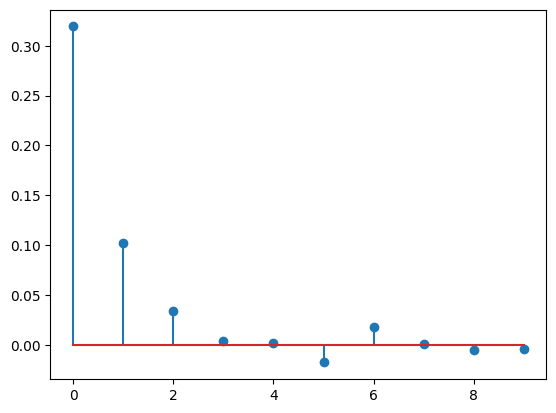

In [9]:
sinusoid = torchhd.embeddings.Projection(3480, 3480, vsa="HRR")

testset = xr.apply_ufunc(
    sinusoid,
    torchhd.HRRTensor(dataset.sel(radius=10).values),
    vectorize=True)

frequency_embeddings = torchhd.HRRTensor(torch.randn(10, 3480))

# Check if the shape of our hypervectors are the same
# print(testset.shape, radius_embeddings.shape)

kbe = torchhd.hash_table(testset, frequency_embeddings)

# Let's assume we want to retrieve the radius size for the first signal in our testset@1MHz
query = torchhd.inverse(testset[0])
result = torchhd.bind(kbe, query)

# Now let's perform a memory cleanup: the result vector should be the closest to our simulated signal at frequency=1MHz
print(torchhd.cleanup(result, frequency_embeddings))

torchhd.utils.plot_similarity(result, frequency_embeddings)



HRRTensor([[-0.1770,  0.8626,  1.1483,  ..., -0.0377, -0.3045,  1.0793]])


<StemContainer object of 3 artists>

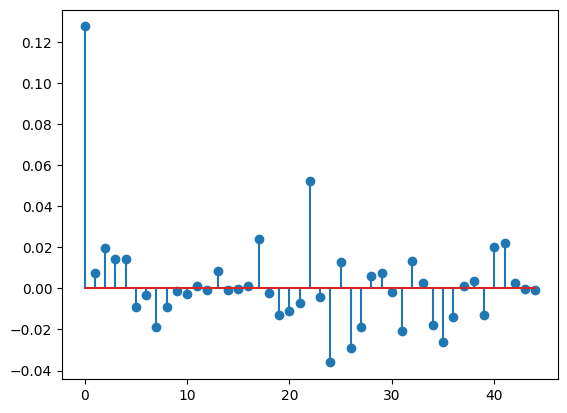

In [10]:
sinusoid = torchhd.embeddings.Projection(3480, 3480, vsa="HRR")

keys = torchhd.HRRTensor(torch.randn(45, 3480))
values = torchhd.HRRTensor(torch.randn(45, 3480))

kbe = torchhd.hash_table(keys, values)
query = torchhd.inverse(keys[0])
result = torchhd.bind(kbe, query)

print(torchhd.cleanup(result, values))
torchhd.utils.plot_similarity(result, values)

Let's test our **hdencode()** method starting from some random values; we can use this technique to create labeling hypervectors for both central frequencies and radii size.

In [11]:

no_radii = dataset.radius.size
no_frequencies = dataset.frequency.size
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

frequency_embeddings = hdencode(
    torch.randn(no_frequencies, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

radius_embeddings = hdencode(
    torch.randn(no_radii, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

print(f"Frequencies embeddings: {np.shape(frequency_embeddings)}")
print(f"Radii embeddings: {np.shape(radius_embeddings)}")
print(frequency_embeddings)


TypeError: hdencode() got multiple values for argument 'in_features'

Since we have **hdencode()** at our disposal, we can use it to test its capabitilies. We will take the signals generated by *all* the central frequencies resonating on an acoustic trap of radius=300 (micrometers), and use them to create a classifying dictionary. Let's encode our signals using a *density*-based sampling.

In [ ]:
testset_embeddings = torch.tensor(dataset.sel(radius=300).values)
signal_embeddings = xr.apply_ufunc(
    hdencode,
    testset_embeddings,
    dataset.time.size,
    embedding_size,
    "density",
    vsa_encoding,
    vectorize=True)
print(f"Signals embeddings: {np.shape(signal_embeddings)}")
print(signal_embeddings)

Signals embeddings: torch.Size([10, 1024])
BSCTensor([[False, False, False,  ..., False,  True, False],
           [ True, False, False,  ..., False,  True, False],
           [False, False, False,  ..., False,  True, False],
           ...,
           [False,  True,  True,  ..., False,  True, False],
           [ True, False, False,  ..., False,  True, False],
           [False, False, False,  ..., False,  True, False]])


At this point, we have 10 signal embeddings (all frequencies, radius=300), and 10 central frequencies embeddings. We can use the latter as keys, while the former as values of our dictionary. From now on, we will refer to this kind of dictionaries to **kbe**s -knowledge base embeddings-, since their role is to preserve the categorical structure of our dataset. Let's create our kbe, and then we will test it using as query the 1MHz frequency embedding (i.e., frequency_embedding[0]). A dictionary lookup using such frequency embedding as key yields a result vector, and this vector should be the closest to the simulated signal parametrized by radius=300 and frequency=1Mhz. To confirm that our dictionary works as expected, the plot should show the highest bar in position 0.

IMPORTANT NOTE: using central frequecies embeddings as keys and signals embeddings as values is a completely arbitrary choice. The results do not change if we invert their role, i.e., signals embeddings as keys, and frequencies embeddings as values.

In [ ]:
# Create the kbe (knowledge base embedding) for radius=300
# Operations syntax:                   bind := * | bundle := +
# kbe[radius=300] :=
#   [frequency=1MHz] * [signal=(radius=10,frequency=1MHz)    +
#   [frequency=1MHz] * [signal=(radius=10,frequency=2MHz)    +
#   ...
#   [frequency=10MHz] * [signal=(radius=10,frequency=9MHz)]  +
#   [frequency=10MHz] * [signal=(radius=10,frequency=10MHz)]

kbe = torchhd.hash_table(frequency_embeddings, signal_embeddings)

# Let's assume we want to know what is the signal like at 1MHz
query = torchhd.inverse(frequency_embeddings[0])
result = torchhd.bind(kbe, query)
# Now let's perform a memory cleanup: the result vector should be the
# closest to our simulated signal at frequency=4MHz
print(torchhd.cleanup(result, signal_embeddings))

torchhd.utils.plot_similarity(result, signal_embeddings)


NameError: name 'signal_embeddings' is not defined

We can see that the result has highest similarity with element in position 0, which corresponds to the embedding of the signal having central frequency equal to 1MHz. We can do a number of simulations to test the accuracy of such classification, and see if our results vary from a dictionary created starting from completely random hypervectors.

In [ ]:
no_simulations = 1000
correct_validations = 0
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

correct_validations = 0
for i in np.arange(no_simulations):
    frequency_embeddings = hdencode(
        torch.randn(no_frequencies, random_embedding_size),
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding)
    query_index = 0   # Our query will be random_keys_embeddings[0]
    query_embedding = frequency_embeddings[query_index]
    correct_result = signal_embeddings[query_index]
    kbe = torchhd.hash_table(frequency_embeddings, signal_embeddings)
    # Let's assume we want to know what is the signal like at 4MHz
    query = torchhd.inverse(query_embedding)
    result = torchhd.bind(kbe, query)
    nearest_match = torchhd.cleanup(result, signal_embeddings)
    # nearest_match = nearest_inner_prod(result, frequency_embeddings)
    if (nearest_match == correct_result).all():
        correct_validations += 1
print(f"Query matching accuracy: {correct_validations / no_simulations * 100}%")

    

Query matching accuracy: 99.8%


Running the subsequent cell, we can observe how we can create symbolic dictionaries starting from completely random hypervectors. This symbolic aspect is one the main advantages of hyperdimensional computing/vector symbolic architectures (HDC/VSA).

<StemContainer object of 3 artists>

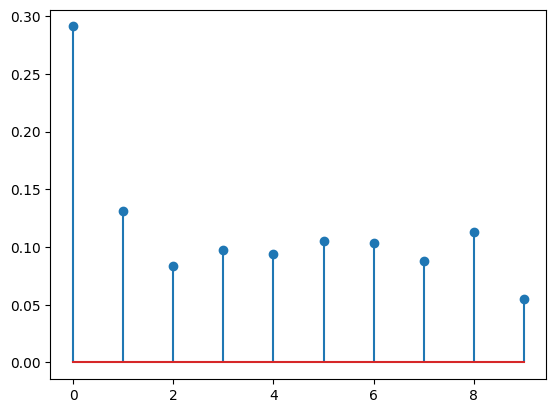

In [ ]:
no_keys, no_values = 10, 10
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

random_keys_embeddings = hdencode(
    torch.randn(no_keys, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding
)
random_values_embeddings = hdencode(
    torch.randn(no_values, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding
)
kbe = torchhd.hash_table(random_keys_embeddings, random_values_embeddings)
query = torchhd.inverse(random_keys_embeddings[0])
result = torchhd.bind(kbe, query)
torchhd.utils.plot_similarity(result, random_values_embeddings)

We can now run a test to compare a kbe entirely build from random hypervectors to a kbe constructed from real-world encoded signals. The parameters of the simulation are the same as before: 100 rounds, size of the embeddings equal to 1024 dimensions, and VSA format based on the BSC (Binary Spatter Codes) encoding.

In [ ]:
no_simulations = 100
correct_validations = 0
no_keys, no_values = 10, 10
embedding_size = 1024
random_embedding_size = 1024
vsa_encoding = "BSC"

for i in np.arange(no_simulations):
    random_keys_embeddings = hdencode(
        torch.randn(no_keys, random_embedding_size),
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding
    )
    random_values_embeddings = hdencode(
        torch.randn(no_values, random_embedding_size),
        in_features=random_embedding_size,
        out_features=embedding_size,
        embed_type="density",
        vsa=vsa_encoding
    )
    query_index = 0   # Our query will be random_keys_embeddings[0]
    query_embedding = random_keys_embeddings[query_index]
    correct_result = random_values_embeddings[query_index]
    kbe = torchhd.hash_table(random_keys_embeddings, random_values_embeddings)
    query = torchhd.inverse(query_embedding)
    result = torchhd.bind(kbe, query)
    nearest_match = torchhd.cleanup(result, random_values_embeddings)
    if (nearest_match == correct_result).all():
        correct_validations += 1
print(f"Query matching accuracy: {correct_validations / no_simulations * 100}%")

Query matching accuracy: 100.0%


The baseline accuracy of correct value retrieval using signals embeddings matches that of random samples. The density-based encoding works as expected, and produces accurate knowledge base embeddings. Up to this point, we have worked with relatively little dimensionality. Since we needed to construct kbes out of superpositions of 10 hypervectors, a size of 1024 dimensions sufficed. In case we want to construct more complex kbes (i.e. hundreds of superpositions), we need a much larger embedding size. As a rule of thumb, when using the BSC encoding, with $1000 \times k$ dimensions we can superimpose $20 \times k$ hypervectors keeping a lookup accuracy of around 99%. We will try now to encode our signals (as well as frequencies and radii labels) using hypervectors of 32768 dimensions.

In [ ]:
no_radii = dataset.radius.size
no_frequencies = dataset.frequency.size
embedding_size = 32768
random_embedding_size = 1024
vsa_encoding = "BSC"

In [ ]:
frequency_embeddings = hdencode(
    torch.randn(no_frequencies, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

radius_embeddings = hdencode(
    torch.randn(no_radii, random_embedding_size),
    in_features=random_embedding_size,
    out_features=embedding_size,
    embed_type="density",
    vsa=vsa_encoding)

Since we have dramatically increased the size of our hypervectors, encoding will be much slower. The following method, **embed()**, will provide a nice way to see the encoding progress, and finally save our signals embeddings to disk.

In [ ]:
def embed(dataset, embedding_size, encoding, vsa_format):
    # To iterate the signal dataset more comfortably, we have to permute radii with frequencies
    tensor_dataset =  torch.tensor(dataset.values).permute(1, 0, 2)

    # Using xArray unnamed function, the probability of memory overflow is extremely high.
    # From both spatial and temporal standpoint, it is more efficient to iterate a torch
    # tensor using standard loops. We will use tqdm to show the embedding phase progress.
    frequencies = tensor_dataset.shape[0]
    radii = tensor_dataset.shape[1]
    signal_embeddings = []
    total_iterations = frequencies * radii

    with tqdm(total=total_iterations, desc="Embedding signals", unit="pair") as pbar:
        for frequency in range(frequencies):
            signal_embeddings_by_radius = []
            for radius in range(radii):
                signal = tensor_dataset[frequency, radius, :]
                signal_embedding = hdencode(signal, dataset.time.size, embedding_size, encoding, vsa_format)
                signal_embeddings_by_radius.append(signal_embedding)
                # Progressbar settings: 1Hz refresh rate
                pbar.update(1) # Update frequency
                pbar.set_postfix(freq=frequency+1, radius=radius*10+10) 
            signal_embeddings.append(signal_embeddings_by_radius)
    return signal_embeddings

Now we can generate our density-based signals embeddings harnessing the method above.

In [ ]:
signal_embeddings = embed(
    dataset,
    embedding_size=32768,
    encoding="density",
    vsa_format="BSC")

Additionally, we can store all the generated embeddings for signals, frequencies and radii into a single xarray data structure, in order to easily handle selections, slicing, and all the other typical operations on vectors.

In [ ]:
signal_embeddings = xr.DataArray(
    signal_embeddings,
    dims=('frequency', 'radius', 'dimension'),
    coords={
        'frequency': np.arange(dataset.frequency.size) + 1,
        'radius': np.arange(dataset.radius.size) * 10 + 10,
        'dimension': np.arange(embedding_size) + 1
    })

frequency_embeddings = xr.DataArray(
    frequency_embeddings,
    dims=('frequency','dimension'),
    coords={
        'frequency': np.arange(np.shape(frequency_embeddings)[0]) + 1,
        'dimension': np.arange(np.shape(frequency_embeddings)[1]) + 1
    })

radius_embeddings = xr.DataArray(
    radius_embeddings,
    dims=('radius','dimension'),
    coords={
        'radius': np.arange(np.shape(radius_embeddings)[0]) * 10 + 10,
        'dimension': np.arange(np.shape(radius_embeddings)[1]) + 1
    })

embeddings = xr.merge([
    signal_embeddings.to_dataset(name="signal_embeddings"),
    frequency_embeddings.to_dataset(name="frequency_embeddings"),
    radius_embeddings.to_dataset(name="radius_embeddings")
])

print(embeddings)

Finally, we will store our embeddings for subsequent reload.

In [ ]:
embeddings.to_netcdf(os.path.join(output_folder, "nrm.orx.embeddings.nc"))

Let's load our embeddings from disk to see if everything looks fine.

In [ ]:
embeddings = xr.load_dataset(os.path.join(input_folder, "nrm.orx.embeddings.nc"))
print(embeddings)

In [ ]:
print(embeddings.signal_embeddings)


In [ ]:
print(embeddings.frequency_embeddings)


In [ ]:
print(embeddings.radius_embeddings)

In order to retrive and use an embedding, we have to first convert it to a BSCTensor (or whatever torchhd format is preferred). The following is an example of such tensor casting.

In [ ]:
test_signal_embedding = embeddings.signal_embeddings.sel(radius=300, frequency=1)
print(test_signal_embedding)
bsc_test_signal_embedding = torchhd.BSCTensor(test_signal_embedding.values)
print(bsc_test_signal_embedding)

Once we have all the embeddings in place, we can finally create the dictionaries to be used as classifiers. First, let's define some notation: 
- $\rho; P \rightarrow$ radius; set of all radii;
- $\phi; \Phi \rightarrow$ frequency; set of all frequencies;
- $\sigma_\rho^\phi \rightarrow$ signal received for acoustic trap of radius $\rho$ at central frequency $\phi$
- $\oplus; \otimes \rightarrow$ superposition or coproduct or bundling; composition or product or binding.
- $\mathtt{kbe}[\phi];\ \mathtt{kbe} \rightarrow$ knowledge base for central frequency $\phi$; knowledge base for all frequencies.

We can produce two classifying solutions, mathematically defined as below:
- a set of 10 dictionaries (one for each frequency $\phi$), each superimposing 45 bindings: $$\mathtt{kbe}[\phi] = \bigoplus\limits_{\rho \in P} \Bigl(\rho \otimes \sigma_\rho^\phi\Bigr)$$
- a single dictionary, embedding 450 bindings: $$\mathtt{kbe} = \bigoplus\limits_{\substack{\rho \in P, \\ \phi \in \Phi}} \Bigl(\phi \otimes \rho \otimes \sigma_\rho^\phi\Bigr)$$

Naturally, we have to provide to preserve both the frequency and the radius embeddings in order to execute the cleanup in subsequent steps.

Let's create first $\mathtt{kbe}[\phi]$, for each central frequency $\phi$.

In [ ]:
kbe_phi = []
signal_embeddings = embeddings.signal_embeddings
frequency_embeddings = embeddings.frequency_embeddings
radius_embeddings = embeddings.radius_embeddings

for i in np.arange(signal_embeddings.frequency.size):
    signal_embeddings_by_radius = signal_embeddings.isel(frequency=i)
    signal_as_key = torchhd.ensure_vsa_tensor(signal_embeddings_by_radius.values)
    radius_as_value = torchhd.ensure_vsa_tensor(radius_embeddings.values)
    kbe = torchhd.hash_table(signal_as_key, radius_as_value)
    kbe_phi.append(kbe)

kbe_phi = xr.DataArray(
    kbe_phi,
    dims=("frequency", "dimension"),
    coords={
        "frequency": np.arange(frequency_embeddings.frequency.size) + 1,
        "dimension": np.arange(frequency_embeddings.dimension.size) + 1
    })

print(kbe_phi)

Let's see if $\mathtt{kbe}[\phi]$ works as expected. We can randomly select a signal and, knowing only the central frequency, let's identify the acoustic trap radius.